Confusion Matrix:
[[ 3427     3     4     0]
 [    9   257     0     0]
 [   15     0 21743     0]
 [    0     2     0     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3434
           1       0.98      0.97      0.97       266
           2       1.00      1.00      1.00     21758
           3       0.00      0.00      0.00         2

    accuracy                           1.00     25460
   macro avg       0.74      0.74      0.74     25460
weighted avg       1.00      1.00      1.00     25460



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


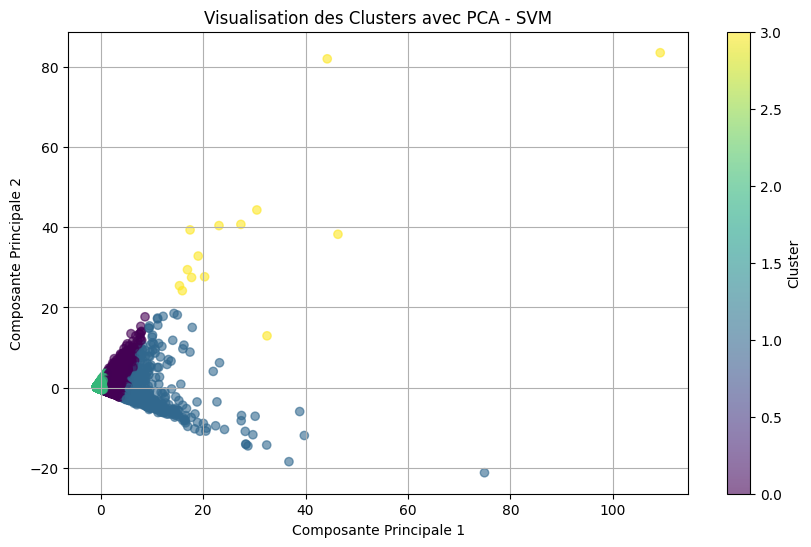

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Charger les données
df = pd.read_parquet("data/user_stats_df_output.parquet")

# Sélectionner les variables pertinentes pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'total_purchase_value'
]

# Filtrer le DataFrame pour ne garder que ces variables et supprimer les valeurs manquantes
X = df[variables_pour_clustering].dropna()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Créer des labels artificiels en utilisant KMeans avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)  # Ajuster à 4 clusters
labels = kmeans.fit_predict(X_scaled)

# Ajouter les labels générés aux données
X['label'] = labels

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=42)

# Appliquer SVM sur les données
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  # Ajustez le kernel, C, et gamma si nécessaire
svm_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test)

# Afficher les résultats
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualisation des clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Clusters')
plt.title('Visualisation des Clusters avec PCA - SVM')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


eps: 0.650, min_samples: 5, clusters: 2, noise points: 153
Silhouette Score: 0.85
eps: 0.650, min_samples: 6, clusters: 2, noise points: 164
Silhouette Score: 0.71
eps: 0.660, min_samples: 5, clusters: 2, noise points: 151
Silhouette Score: 0.85
eps: 0.660, min_samples: 6, clusters: 2, noise points: 163
Silhouette Score: 0.71
eps: 0.670, min_samples: 5, clusters: 2, noise points: 146
Silhouette Score: 0.84
eps: 0.670, min_samples: 6, clusters: 1, noise points: 159
Meilleur eps: 0.65, Meilleur min_samples: 5, Meilleur Score Silhouette: 0.85


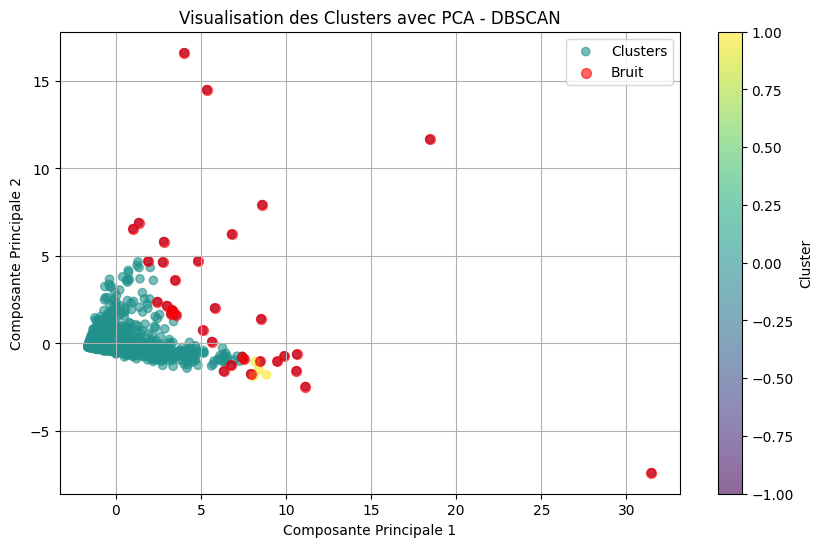

6639

In [3]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score  # Import manquant ajouté ici
import matplotlib.pyplot as plt
import gc

# Chargement des données
df = pd.read_parquet("data/user_stats_df_output.parquet")
X = df[['number_of_views_7m', 'number_of_sessions_7m', 'total_purchase_value']].dropna()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Limitation de la taille de l'échantillon pour le test
sample_size = min(10000, len(X_scaled))  # Limite à 10 000 points ou moins pour tester plus facilement
X_sample = X_scaled[:sample_size]

# Affiner les plages de valeurs pour `eps` autour de 0.65 avec de petits pas
eps_values = [0.65, 0.66, 0.67]  # Ajustez selon les tests précédents
min_samples_values = [5, 6]

best_score = -1
best_eps = None
best_min_samples = None

# Boucle pour tester les combinaisons des paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_sample)
            num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclut le bruit
            num_noise = list(clusters).count(-1)
            print(f"eps: {eps:.3f}, min_samples: {min_samples}, clusters: {num_clusters}, noise points: {num_noise}")

            # Calcul du score silhouette seulement s'il y a au moins 2 clusters
            if num_clusters > 1:
                score = silhouette_score(X_sample[clusters != -1], clusters[clusters != -1])
                print(f"Silhouette Score: {score:.2f}")

                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

            # Nettoyer la mémoire après chaque boucle
            gc.collect()

        except Exception as e:
            print(f"Erreur lors de l'exécution avec eps={eps}, min_samples={min_samples}: {e}")

# Affichage des meilleurs paramètres
print(f"Meilleur eps: {best_eps}, Meilleur min_samples: {best_min_samples}, Meilleur Score Silhouette: {best_score:.2f}")

# Application de DBSCAN avec les meilleurs paramètres trouvés
try:
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    clusters = dbscan.fit_predict(X_sample)

    # Réduire la taille pour la visualisation
    visual_sample_size = min(2000, len(X_sample))
    X_pca = PCA(n_components=2).fit_transform(X_sample[:visual_sample_size])
    clusters_sample = clusters[:visual_sample_size]

    # Visualiser les clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_sample, cmap='viridis', alpha=0.6, label='Clusters')
    plt.scatter(X_pca[clusters_sample == -1, 0], X_pca[clusters_sample == -1, 1], c='red', s=50, alpha=0.6, label='Bruit')
    plt.title('Visualisation des Clusters avec PCA - DBSCAN')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'application de DBSCAN et de la visualisation : {e}")

# Nettoyer la mémoire après l'exécution
gc.collect()


